# AutoEncoders for Supervised Anomaly Detection

## Anomaly Detection: Detecting the Unusual

Anomaly detection is a crucial task in various domains, where the objective is to identify rare and abnormal instances that deviate significantly from the expected or normal behavior. It plays a vital role in fraud detection, network security, system monitoring, and predictive maintenance.

## Autoencoders for Unsupervised Anomaly Detection

In the unsupervised setting, autoencoders are trained to reconstruct the input data accurately. The idea is that the model learns to encode the normal instances in a compressed representation and then decodes them back to their original form. Anomalies, being different from the normal patterns, are expected to have higher reconstruction errors. By setting a suitable threshold on the reconstruction error, anomalies can be identified.

## Incorporating Supervision with Autoencoder Features

**In this exercise, we will explore a different approach by incorporating supervision into the anomaly detection process. We will still employ autoencoders, but instead of relying solely on the reconstruction error for anomaly detection, we will leverage the learned features from the encoder part of the autoencoder and utilize them to train a supervised classifier to detect anomalies.**

In this exercise you will:



*   Learn how to train AutoEncoders on Relational Data.
*   Learn how compressed representations from an AutoEncoder can help achieve performance comparable to original dimensions on downstream task.
*   Learn how to use AutoEncoder for Supervised Anomaly Detection tasks.





*This notebook is designed to help you guide how to approach this assignment.*

<i><font color='blue'>Some parts of the notebook are left as exercise for you and are the corresponding headers are marked in blue</font></i>

# Exploring the Dataset

* Create a directory called **kdd-data** in the root (**My Drive**) of your Google Drive.
* Upload the provided **kdd-data.zip** to this **kdd-data** directory.

## Importing the required libraries

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Model, models
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns

## Mount the Google Drive

After mounting the drive, the **kdd-data.zip** should appear at the following path in the left (**Files**) pane in Colab: **/content/gdrive/MyDrive/kdd-data/kdd-data.zip.**

If it doesn't, make sure you recheck and follow the steps mentioned above.

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/kdd-data/'
if not os.path.isdir(path):
  os.mkdir(path)

## Upzip the Data Zip Archive

In [5]:
#should only need to unzip once
!unzip /content/kdd-data.zip -d /content/kdd-data/

Archive:  /content/kdd-data.zip
  inflating: /content/kdd-data/corrected.gz  
  inflating: /content/kdd-data/corrected/corrected  
  inflating: /content/kdd-data/kddcup.data.corrected  
  inflating: /content/kdd-data/kddcup.data.gz  
  inflating: /content/kdd-data/kddcup.data/kddcup.data  
  inflating: /content/kdd-data/kddcup.data_10_percent.gz  
  inflating: /content/kdd-data/kddcup.data_10_percent/kddcup.data_10_percent  
  inflating: /content/kdd-data/kddcup.data_10_percent_corrected  
  inflating: /content/kdd-data/kddcup.names  
  inflating: /content/kdd-data/kddcup.newtestdata_10_percent_unlabeled.gz  
  inflating: /content/kdd-data/kddcup.newtestdata_10_percent_unlabeled/kddcup.newtestdata_10_percent_unlabeled  
  inflating: /content/kdd-data/kddcup.testdata.unlabeled.gz  
  inflating: /content/kdd-data/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled  
  inflating: /content/kdd-data/kddcup.testdata.unlabeled_10_percent.gz  
  inflating: /content/kdd-data/kddcup.testdata.unl

The uncompressed data should now be available under **/content/gdrive/MyDrive/kdd-data/**

## Description of the KDD Cup 1999 Data

The KDD Cup 1999 dataset is a widely used benchmark dataset in the field of anomaly detection and network security. It was created as part of the Third International Knowledge Discovery and Data Mining Tools Competition, held in 1999.

The dataset contains a large set of network traffic data captured from various sources, simulating a network environment. It includes a wide range of features that represent different aspects of network connections, such as duration, protocol type, service, flag, source and destination bytes, and more.

The primary goal of the KDD Cup 1999 dataset is to classify network connections as either "normal" or "anomalous."

The dataset includes a categorical label column called "label," which categorizes network connections into various attack types, such as "normal," "dos" (denial-of-service), "probe" (scanning and probing), "r2l" (unauthorized access from a remote machine), and "u2r" (unauthorized access to local root privileges).

## Loading the dataset

The KDD Dataset contains around 5 million instances of network traffic data. Each instance represents a network connection with various features and a corresponding label.

Due to the resource limitations in Colab, we will utilize a smaller subset of the data by using a 10% split (kddcup.data_10_percent) for training our models. This subset will allow us to work within the resource constraints while still providing enough data for training and evaluation.

The description of the dataset, along with the features is available [here](https://kdd.ics.uci.edu/databases/kddcup99/task.html).

The dataset file doesn't contain any header. Therefore loading the header information about the dataset as described [here](https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names).

In [6]:
# Load the KDD Cup 1999 dataset

data = pd.read_csv('/content/kdd-data/kddcup.data_10_percent/kddcup.data_10_percent', header=None)

In [7]:
# Define the column names
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                "num_failed_logins", "logged_in", "num_compromised",
                "root_shell", "su_attempted", "num_root", "num_file_creations",
                "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count",
                "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
                "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
                "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                "dst_host_srv_serror_rate", "dst_host_rerror_rate",
                "dst_host_srv_rerror_rate", "label"]

# Assign the column names to the dataset
data.columns = column_names

## Checkout the first few rows of the dataset

In [8]:
pd.set_option('display.max_columns', None)
data.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


In [9]:
data.shape

(494021, 42)

## Label Fequency

<font color='blue'>Create a Bar Plot to check the frequency for each label in the dataset</font>

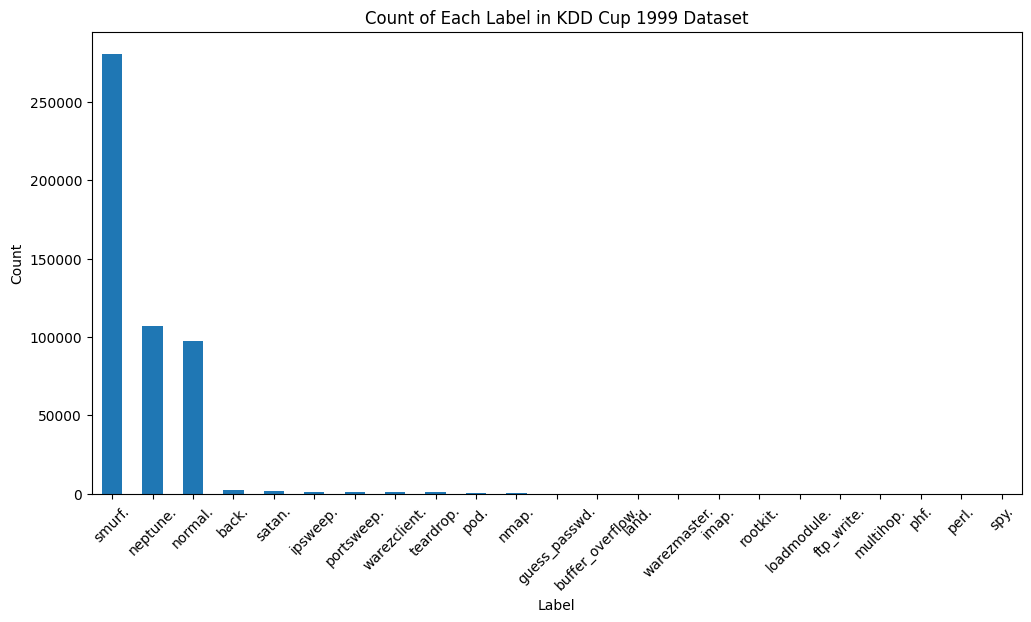

In [10]:
def plot_value_count(data):

  # Count the occurrences of each label
  label_counts = data['label'].value_counts()

  # Create a bar plot
  plt.figure(figsize=(12, 6))
  label_counts.plot(kind='bar')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Count of Each Label in KDD Cup 1999 Dataset')
  plt.xticks(rotation=45)
  plt.show()

plot_value_count(data)

### All classes except "normal." in this dataset are considered attacks. They can be considered anomalies in our case.

Since our goal is to classify the network traffic as "normal" or "anomalous", we just need to convert the remaining classes into these two, and project this as a binary classification problem.

<font color='blue'>Convert all "normal" labels to a value "0", while all other labels to a value "1". Update the same "label" column in the "data" dataframe with the new values.</font>

In [11]:
data["label"] = data["label"].apply(lambda x: 0 if x == "normal." else 1)

Let's look at the label frequency now

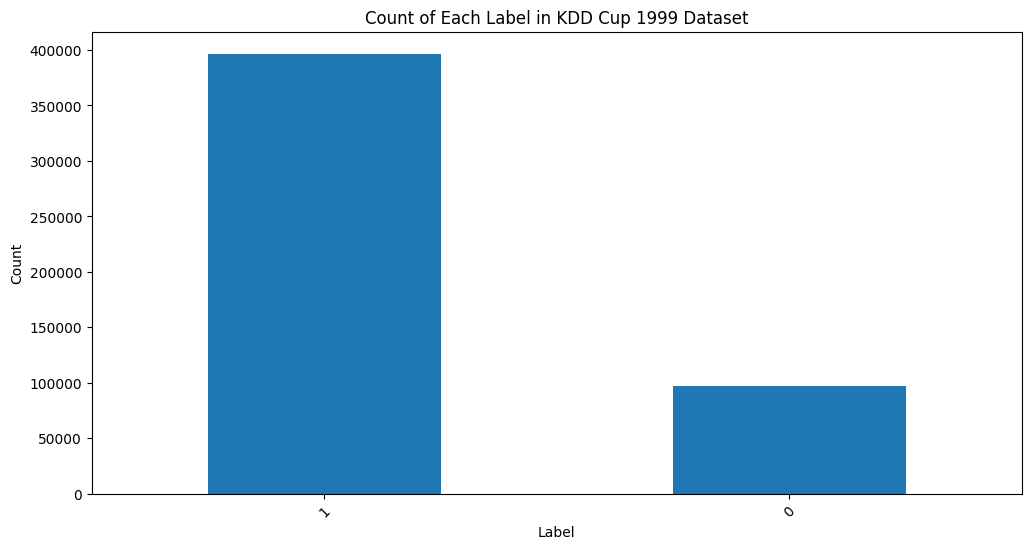

In [12]:
# the "label" column in the data df should contain the two labels "0" and "1" now.
plot_value_count(data)

In [13]:
data.label.value_counts(normalize=True)

,proportion
label,
1,0.803089
0,0.196911


Since we have the labels available for anomalous and non amomalous datapoints, this dataset is a good candidate for supervised anomaly detection.

Note that anomaly detection datasets usually have "less" anomalous data points than non-anomalous dataset, however, this is not the case in this dataset, even without binarizing the labels. Since, the dataset has **significant** number of anomalous datapoints, this also makes it a good candidate for Supervised Anomaly Detection.

## Splitting the dataset before Preprocessing

In [14]:
# Separate the labels from the features
X = data.drop("label", axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Processing the Categorical Features

Let's look at the dataset description and figure out all the categorical features available in the dataset.





In [15]:
categorical_features = ["protocol_type", "service", "flag"]

<font color='blue'>Now convert the categorical features in One Hot representation. The code should update the X_train and X_test dataframes, with the one hot encoded features, and the original features dropped.</font>

In [19]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_data_train = X_train[categorical_features]
categorical_data_test = X_test[categorical_features]

# Fit and transform the categorical features for training data
one_hot_data_train = encoder.fit_transform(categorical_data_train)

# Transform the categorical features for test data
one_hot_data_test = encoder.transform(categorical_data_test)

# Create DataFrames with the one-hot encoded features
one_hot_df_train = pd.DataFrame(one_hot_data_train, columns=encoder.get_feature_names_out(categorical_features))
one_hot_df_test = pd.DataFrame(one_hot_data_test, columns=encoder.get_feature_names_out(categorical_features))

# Drop the original categorical features
X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

# Concatenate the one-hot encoded features with the original datasets
X_train = pd.concat([X_train.reset_index(drop=True), one_hot_df_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), one_hot_df_test], axis=1)

In [20]:
encoder.get_feature_names_out(categorical_features)

array(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth',
       'service_bgp', 'service_courier', 'service_csnet_ns',
       'service_ctf', 'service_daytime', 'service_discard',
       'service_domain', 'service_domain_u', 'service_echo',
       'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec',
       'service_finger', 'service_ftp', 'service_ftp_data',
       'service_gopher', 'service_hostnames', 'service_http',
       'service_http_443', 'service_imap4', 'service_iso_tsap',
       'service_klogin', 'service_kshell', 'service_ldap', 'service_link',
       'service_login', 'service_mtp', 'service_name',
       'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn',
       'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u',
       'service_other', 'service_pm_dump', 'service_pop_2',
       'service_pop_3', 'service_printer', 'service_private',
       'service_

Let's look at the new shape of our encoded dataset

In [21]:
print(X_train.shape)
print(X_test.shape)

(395216, 117)
(98805, 117)


## Normalizing the Continous Features

The continous (non-categorical) features in the KDD dataset have different scales. This can be a problem for our models. Let's normalize these features.

In [25]:
continuous_features = [x for x in column_names if x not in categorical_features and x !='label']
print('Total number of non-categorical features: ', len(continuous_features))

Total number of non-categorical features:  38


<font color='blue'>Write code to normalize the non categorical features in the dataset. The code should update X_train and X_test dataframes.</font>

In [26]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the continuous features in X_train
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])

# Transform the continuous features in X_test
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# Display the normalized datasets
print("Normalized Training Data:")
X_train.sample(8)
#print("\nNormalized Test Data:")
#print(X_test.sample(8))

Normalized Training Data:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
378509,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209393,0.017613,1.0,1.0,0.0,0.0,0.08,0.06,0.0,1.000000,0.062745,0.06,0.07,0.00,0.00,1.00,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
65403,0.000000,0.000001,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.00,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378965,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.00,0.00,0.0,0.011765,0.933333,1.00,0.00,0.33,0.24,0.00,0.00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280428,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497065,0.039139,1.0,1.0,0.0,0.0,0.08,0.05,0.0,1.000000,0.074510,0.07,0.07,0.00,0.00,1.00,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
82074,0.000000,0.000001,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.00,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Modelling

## AutoEncoder

Now that the train and test data is ready. Let's design an AutoEncoder.

### Encoder

<font color='blue'>Design an Encoder. Take any aribitrary number of Dense Layers, with arbitrary number of neurons in each layers. The output dimensions should be significantly less than the number of dimensions in the Training Dataset. Feel free to try out various architectures here and use the one yeilding best results. The encoder should be an object of "Model" class</font>

In [27]:
print(X_train.shape)

(395216, 117)


In [28]:
input_dim = X_train.shape[1]
encoding_dim = 4

input_data = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_data)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

encoder = Model(input_data, encoded)

encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 117)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,764 (38.14 KB)

 Trainable params: 9,764 (38.14 KB)

 Non-trainable params: 0 (0.00 B)

<font color='blue'>Design the decoder. The architecture of the Decoder should complement the Encoder. The decoder should be an object of "Model" class</font>

In [29]:
# Decoder model
encoded_input = layers.Input(shape=(encoding_dim,))
decoded = layers.Dense(32, activation='relu')(encoded_input)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)
decoder = Model(encoded_input, decoded)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 117)            │         7,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,877 (38.58 KB)

 Trainable params: 9,877 (38.58 KB)

 Non-trainable params: 0 (0.00 B)

<font color='blue'>Combine encoder and decoder to produce the final model.</font>

In [31]:
# Autoencoder model
autoencoder_encoded = encoder(input_data)
autoencoder_decoded = decoder(autoencoder_encoded)
autoencoder = Model(input_data, autoencoder_decoded)

autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 117)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 4)              │         9,764 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 117)            │         9,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,641 (76.72 KB)

 Trainable params: 19,641 (76.72 KB)

 Non-trainable params: 0 (0.00 B)

<font color='blue'>Compile and Train the AutoEncoder on X_train. Feel free to try out various hyperparameters, and/or try various hyperparameter search techniques.</font>

In [32]:
# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=256, validation_data=(X_test, X_test))

Epoch 1/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.2416 - val_loss: 0.1677
Epoch 2/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1246 - val_loss: 0.0440
Epoch 3/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0379 - val_loss: 0.0280
Epoch 4/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0263 - val_loss: 0.0208
Epoch 5/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0191 - val_loss: 0.0143


<font color='blue'>Create a plot to visualize the training and validation loss</font>

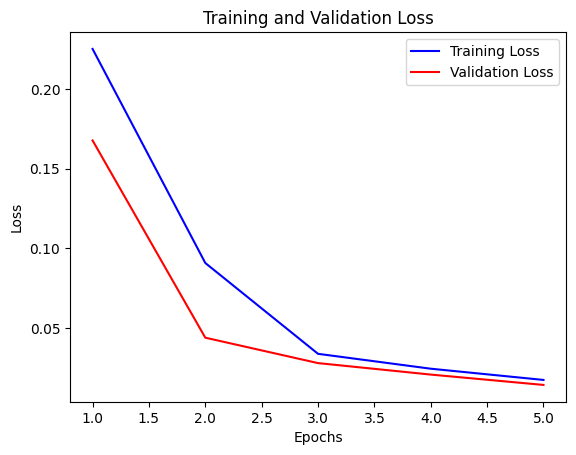

In [33]:
# Access the loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Classifier

The AutoEncoder can now give us a latent space from the Encoder, with the features representing the maximum information from the original set of 117 features. The task is to build a classifier, use this latent space from the AutoEncoder as input features to the classifier, and see if the classifier can predict network attacks accurately.

<font color='blue'> Build a classifier here. You are free to use any architecture i.e. non-neural models such as Logistic Regression, Decision Trees, Random Forest etc. or a Sequential Feed Forward Neural Network. </font>

In [34]:
def get_classifier(input_dimension, lr):
  classifier = models.Sequential()
  classifier.add(layers.Dense(64, activation='relu', input_dim=input_dimension))
  classifier.add(layers.Dense(32, activation='relu'))
  classifier.add(layers.Dense(1, activation='sigmoid'))
  classifier.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

  return classifier

### Classification on the non-autoencoded dataset

<font color='blue'>Train the classifier on the original data first - i.e. on X_train. You do not need to worry about the AutoEncoder's output in this exercise.</font>

In [35]:
# Train the classifier model
classifier = get_classifier(input_dim, 1e-5)
classifier.fit(X_train, y_train, epochs=5, batch_size=256, shuffle=True, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3729 - loss: 0.7495 - val_accuracy: 0.9526 - val_loss: 0.5281
Epoch 2/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9546 - loss: 0.4691 - val_accuracy: 0.9661 - val_loss: 0.3111
Epoch 3/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9722 - loss: 0.2705 - val_accuracy: 0.9896 - val_loss: 0.1697
Epoch 4/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9900 - loss: 0.1462 - val_accuracy: 0.9882 - val_loss: 0.0933
Epoch 5/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9884 - loss: 0.0821 - val_accuracy: 0.9882 - val_loss: 0.0600


<font color='blue'>Generate predictions on the X_test, Generate Classification Report and plot confusion matrix</font>

In [36]:
# Predict on the test set
y_pred = classifier.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Evaluate the classifier
print("Classifier Metrics:")
print(classification_report(y_test, y_pred))

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Classifier Metrics:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     19353
           1       1.00      0.99      0.99     79452

    accuracy                           0.99     98805
   macro avg       0.98      0.99      0.98     98805
weighted avg       0.99      0.99      0.99     98805



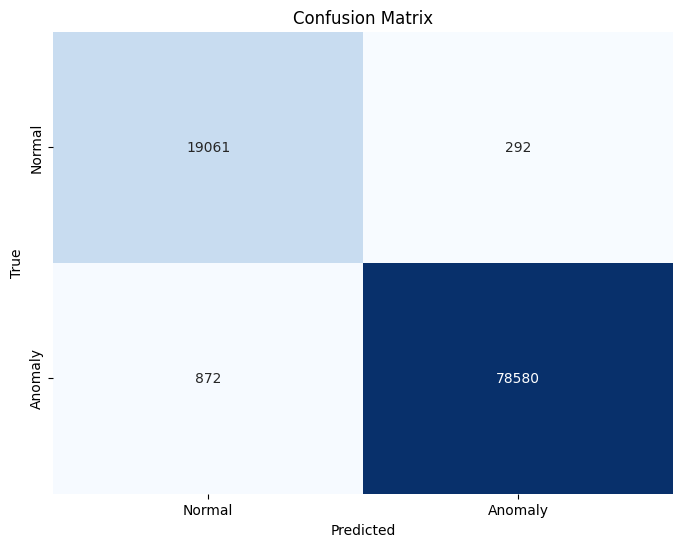

In [37]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Classification on the Autoencoded dataset

<font color='blue'>Write code to generate latent representations for X_train and X_test from the Encoder component of the AutoEncoder</font>

In [38]:
# Obtain the encoded features
encoded_train_features = encoder.predict(X_train)
encoded_test_features = encoder.predict(X_test)

12351/12351 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [39]:
print(X_train.shape)
print(encoded_train_features.shape)

(395216, 117)
(395216, 4)


In [40]:
encoded_train_features

array([[ 6.8806076 ,  0.        , 11.129404  ,  0.        ],
       [ 0.        ,  0.        ,  7.9867587 ,  0.        ],
       [ 0.08320239,  0.        ,  8.208569  ,  0.        ],
       ...,
       [ 6.8806076 ,  0.        , 11.129403  ,  0.        ],
       [ 3.4896438 ,  0.        ,  7.7923245 ,  0.        ],
       [ 0.        ,  0.        ,  7.912419  ,  0.        ]],
      dtype=float32)

<font color='blue'>Now train the classifier on these latent representations. You should try out various hyperparameters which your classifier can take in order to achieve the best performance.</font>

In [41]:
classifier=get_classifier(encoding_dim, 3e-5)
classifier.fit(encoded_train_features, y_train, epochs=5, batch_size=256, validation_data=(encoded_test_features, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1544/1544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7484 - loss: 0.5044 - val_accuracy: 0.8041 - val_loss: 0.4009
Epoch 2/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8028 - loss: 0.3856 - val_accuracy: 0.8041 - val_loss: 0.3182
Epoch 3/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8235 - loss: 0.2826 - val_accuracy: 0.9650 - val_loss: 0.1733
Epoch 4/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9706 - loss: 0.1491 - val_accuracy: 0.9811 - val_loss: 0.0930
Epoch 5/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9828 - loss: 0.0835 - val_accuracy: 0.9866 - val_loss: 0.0650


<font color='blue'>Generate predictions on the X_test, Generate Classification Report and plot confusion matrix.</font>

In [42]:
# Predict on the test set
y_pred = classifier.predict(encoded_test_features)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Evaluate the classifier
print("Classifier Metrics:")
print(classification_report(y_test, y_pred))

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Classifier Metrics:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     19353
           1       0.99      0.99      0.99     79452

    accuracy                           0.99     98805
   macro avg       0.97      0.98      0.98     98805
weighted avg       0.99      0.99      0.99     98805



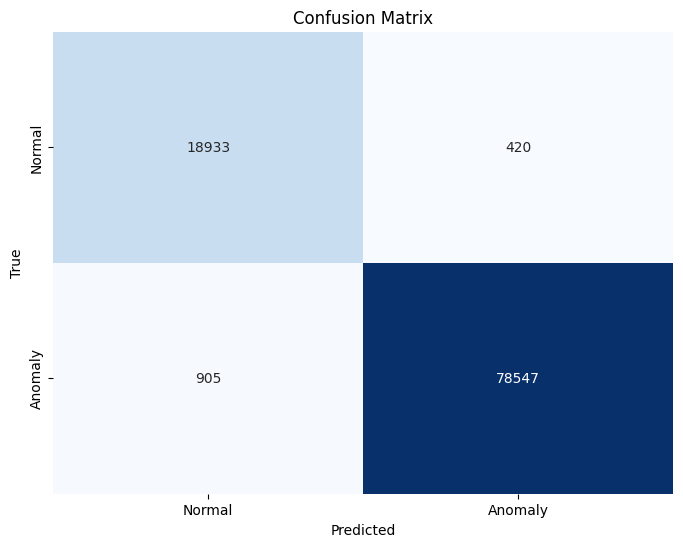

In [43]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Summary

<font color='blue'>Summarize your observations when training the classifier on the Raw Features vs training it on the encoded features.

Compare and Summarize the results of the two approaches.</font>

* **Effective Compression**: The autoencoder successfully compressed the high-dimensional KDD dataset into a lower-dimensional latent representation. Despite the dimensionality reduction, the classifier trained on the compressed features achieved competitive performance compared to using the full dimensions.

* **Noise and Irrelevant Features**: The dimensionality reduction process likely helped in removing or reducing the impact of noise and irrelevant features present in the original dataset. By focusing on the most informative aspects, the classifier performed well, suggesting that the autoencoder captured the essential information for anomaly detection.

* **Improved Robustness**: The compressed latent dimensions learned by the autoencoder potentially captured the underlying patterns and structures of the dataset. As a result, the classifier trained on these compressed features showed improved robustness to anomalies and variations in the data, leading to competitive performance.